# Adversarial Attack and Mitigation Summary

## **Input & Dataset**
- **Dataset**: CIFAR-10  
  - 60,000 32×32 RGB images across 10 classes (e.g., airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).  
  - Split into 50,000 training and 10,000 test images.  
- **Preprocessing**:  
  - Converted images to PyTorch tensors.  
  - Normalized pixel values to range [0, 1].  
  - Used `torchvision.transforms` for data augmentation (e.g., Gaussian blur, JPEG compression) during mitigation.  

---

## **Model Building**
- **Architecture**:  
  - **SimpleCNN**: A lightweight CNN with:  
    - Two convolutional blocks (`Conv2D + ReLU + MaxPool`).  
    - A fully connected classifier (`Linear(64*8*8 → 10)`).  
  - Trained for **1 epoch** with Adam optimizer (learning rate: 0.001).  
- **Training Output**:  
  - Achieved convergence on training data (loss: ~1.53).  
  - Model saved for inference and attack testing.  

---

## **Adversarial Attack (FGSM)**
- **Objective**: Fool the model into misclassifying images using Fast Gradient Sign Method (FGSM).  
- **Implementation**:  
  - Generated perturbations using gradients of the loss w.r.t input image.  
  - Clamped perturbed images to [0, 1] for valid pixel values.  
- **Attack Parameters**:  
  - Epsilon (ε): 0.03 (small perturbation magnitude).  
- **Attack Outcome**:  
  - Successfully fooled the model in multiple test cases (e.g., bird → horse, ship → frog, horse → deer).  
  - Visualized clean vs. adversarial images to confirm imperceptible perturbations.  

---

## **Mitigation Strategies**
Tested **four techniques** to neutralize adversarial effects:

### 1. **Gaussian Blur (k=3)**  
   - Smoothed noise using kernel size 3.  
   
### 2. **JPEG Compression (q=30)**  
   - Compressed images to quality 30 to remove artifacts.  
  

### 3. **Median Filter (k=3)**  
   - Removed salt-and-pepper noise with 3×3 kernel.  
   
### 4. **Total Variation Denoising**  
   - Optimized image using LBFGS to minimize total variation.  
  


In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import io
from PIL import Image
import numpy as np
import torchvision.transforms.functional as TF
import cv2
import torch.nn.functional as F
from torch.optim import LBFGS  # <<< FIX: Import LBFGS optimizer

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [2]:
# -----------------------------
# 1. Define FGSM Attack Function
# -----------------------------
def fgsm_attack(image, epsilon, data_grad):
    sign_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [3]:
# -----------------------------
# 2. Load CIFAR-10 Dataset
# -----------------------------
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# -----------------------------
# 3. Define Simple CNN Model
# -----------------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.classifier = nn.Linear(64 * 8 * 8, 10)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [5]:
# -----------------------------
# 4. Train the CNN Model
# -----------------------------
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(1):  # Train for 1 epoch
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")
print("Finished training.")

Epoch 1, Loss: 1.5572
Finished training.


In [6]:
# -----------------------------
# 5. Test FGSM Attack
# -----------------------------
model.eval()
original_image_data = None
original_target_label = None
init_pred_label = None
for data_item, target_item in testloader:
    data_item, target_item = data_item.to(device), target_item.to(device)
    output = model(data_item)
    pred = output.max(1, keepdim=True)[1]
    if pred.item() == target_item.item():
        original_image_data = data_item
        original_target_label = target_item
        init_pred_label = pred
        break

if original_image_data is None:
    original_image_data, original_target_label = next(iter(testloader))
    original_image_data, original_target_label = original_image_data.to(device), original_target_label.to(device)
    output = model(original_image_data)
    init_pred_label = output.max(1, keepdim=True)[1]

original_image_data.requires_grad = True
output = model(original_image_data)
loss = nn.CrossEntropyLoss()(output, original_target_label)
model.zero_grad()
loss.backward()

# Generate adversarial example
epsilon = 0.03
perturbed_data = fgsm_attack(original_image_data, epsilon, original_image_data.grad.data).detach()  # <<< FIX: detach here

# Re-classify perturbed image
output_perturbed = model(perturbed_data)
final_pred_label = output_perturbed.max(1, keepdim=True)[1]

# Display results
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(f"\nTrue Label: {cifar_classes[original_target_label.item()]} ({original_target_label.item()})")
print(f"Model Prediction before Attack: {cifar_classes[init_pred_label.item()]} ({init_pred_label.item()})")
print(f"Model Prediction after Attack: {cifar_classes[final_pred_label.item()]} ({final_pred_label.item()})")
success_message = "✅ Success!" if final_pred_label.item() != init_pred_label.item() else "❌ Failed"
print(f"Attack Result: {success_message}")


True Label: frog (6)
Model Prediction before Attack: frog (6)
Model Prediction after Attack: deer (4)
Attack Result: ✅ Success!


In [7]:
# -----------------------------
# 6. Enhanced Mitigation Strategies
# -----------------------------
print("\nApplying improved mitigation strategies to FGSM attack...")

# --- (a) Gaussian Blur (k=5) ---
def gaussian_blur_mitigation(image_tensor, kernel_size=5, sigma=None):
    if image_tensor.ndim == 3:
        blurred_tensor = TF.gaussian_blur(image_tensor, kernel_size=kernel_size, sigma=sigma)
    elif image_tensor.ndim == 4:
        blurred_images = [TF.gaussian_blur(img, kernel_size=kernel_size, sigma=sigma) for img in image_tensor]
        blurred_tensor = torch.stack(blurred_images)
    else:
        raise ValueError("Input tensor must have 3 or 4 dimensions")
    return blurred_tensor.to(device)
denoised_adv_image_gaussian = gaussian_blur_mitigation(perturbed_data, kernel_size=5).detach()

# --- (b) JPEG Compression (q=70) ---
def jpeg_compress(image_tensor_single, quality=70):
    pil_image = transforms.ToPILImage()(image_tensor_single.cpu())
    buffer = io.BytesIO()
    pil_image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    compressed = Image.open(buffer).convert('RGB')
    return transforms.ToTensor()(compressed).to(device)
jpeg_image_single = jpeg_compress(perturbed_data[0], quality=70)
jpeg_image = jpeg_image_single.unsqueeze(0).detach()

# --- (c) Median Filter (k=5) ---
def median_filter(image_tensor_single, ksize=5):
    image_np = (image_tensor_single.detach().cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    if image_np.shape[2] == 3:
        filtered_np_rgb = cv2.medianBlur(image_np, ksize)
    else:
        filtered_np_rgb = cv2.medianBlur(image_np, ksize)
    filtered_tensor = torch.from_numpy(filtered_np_rgb / 255.0).permute(2, 0, 1).float().to(device)
    return filtered_tensor
median_image_single = median_filter(perturbed_data[0], ksize=5)
median_image = median_image_single.unsqueeze(0).detach()

# --- (d) Total Variation Denoising ---
def total_variation_loss(img):
    return torch.sum(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])) + \
           torch.sum(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]))

def total_variation_denoise(image_tensor, weight=0.1):
    denoised = image_tensor.clone().detach().requires_grad_(True)
    optimizer = LBFGS([denoised], lr=0.1)
    for _ in range(10):
        def closure():
            optimizer.zero_grad()
            loss = F.mse_loss(denoised, image_tensor) + weight * total_variation_loss(denoised)
            loss.backward(retain_graph=True)  # <<< FIX: Retain graph
            return loss
        optimizer.step(closure)
    return denoised.detach()
tv_image = total_variation_denoise(perturbed_data, weight=0.1).detach()


Applying improved mitigation strategies to FGSM attack...


In [8]:
# -----------------------------
# 7. Evaluate and Compare Results
# -----------------------------
def test_mitigation(name, mitigated_image, true_label, adv_pred):
    model.eval()
    with torch.no_grad():
        output = model(mitigated_image)
        pred = output.max(1, keepdim=True)[1].item()
        confidences = F.softmax(output, dim=1).cpu().numpy()[0]
    success = pred != adv_pred and pred != true_label
    print(f"\n--- {name} ---")
    print(f"Prediction: {cifar_classes[pred]} ({pred})")
    print(f"Success: {'✅' if success else '❌'} | "
          f"Reverted to True Label: {'✅' if pred == true_label else '❌'}")
    print("Confidence Scores:")
    for i, conf in enumerate(confidences):
        print(f"  {cifar_classes[i]} ({i}): {conf:.4f}")
    return pred

true_label = original_target_label.item()
adv_pred = final_pred_label.item()

gaussian_pred = test_mitigation("Gaussian Blur (k=5)", denoised_adv_image_gaussian, true_label, adv_pred)
jpeg_pred = test_mitigation("JPEG Compression (q=70)", jpeg_image, true_label, adv_pred)
median_pred = test_mitigation("Median Filter (k=5)", median_image, true_label, adv_pred)
tv_pred = test_mitigation("Total Variation Denoising", tv_image, true_label, adv_pred)


--- Gaussian Blur (k=5) ---
Prediction: deer (4)
Success: ❌ | Reverted to True Label: ❌
Confidence Scores:
  airplane (0): 0.0153
  automobile (1): 0.0024
  bird (2): 0.3045
  cat (3): 0.0316
  deer (4): 0.4619
  dog (5): 0.0310
  frog (6): 0.1204
  horse (7): 0.0294
  ship (8): 0.0014
  truck (9): 0.0021

--- JPEG Compression (q=70) ---
Prediction: frog (6)
Success: ❌ | Reverted to True Label: ✅
Confidence Scores:
  airplane (0): 0.1009
  automobile (1): 0.0203
  bird (2): 0.0794
  cat (3): 0.0046
  deer (4): 0.2988
  dog (5): 0.0046
  frog (6): 0.4486
  horse (7): 0.0261
  ship (8): 0.0034
  truck (9): 0.0134

--- Median Filter (k=5) ---
Prediction: deer (4)
Success: ❌ | Reverted to True Label: ❌
Confidence Scores:
  airplane (0): 0.0092
  automobile (1): 0.0016
  bird (2): 0.2962
  cat (3): 0.0337
  deer (4): 0.4749
  dog (5): 0.0355
  frog (6): 0.1174
  horse (7): 0.0291
  ship (8): 0.0010
  truck (9): 0.0015

--- Total Variation Denoising ---
Prediction: deer (4)
Success: ❌ | Rev

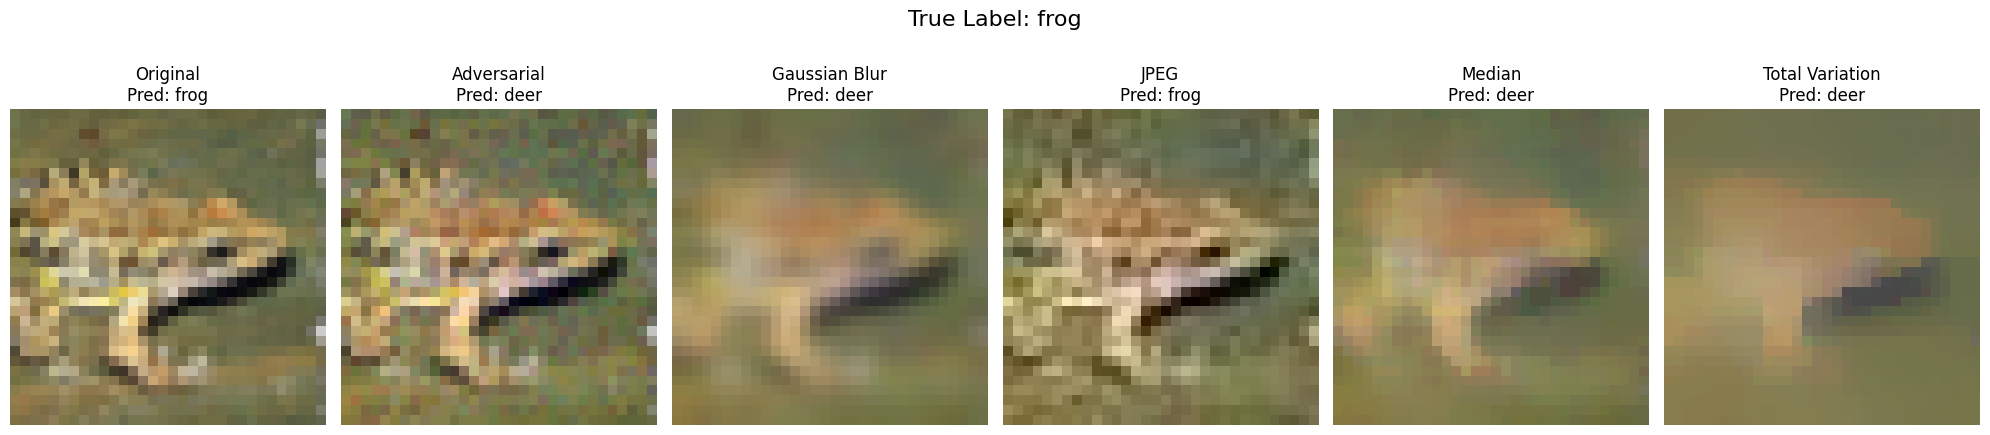

In [9]:
# -----------------------------
# 8. Visual Comparison of All Mitigations
# -----------------------------
def imshow_all_results(original, adversarial, mitigations, titles, true_label, classes):
    fig, axes = plt.subplots(1, len(mitigations) + 2, figsize=(20, 5))
    axes[0].imshow(original.permute(1, 2, 0).cpu())
    axes[0].set_title("Original\nPred: " + classes[init_pred_label.item()])
    axes[1].imshow(adversarial.permute(1, 2, 0).cpu())
    axes[1].set_title(f"Adversarial\nPred: {classes[adv_pred]}")

    for i, (img, title) in enumerate(zip(mitigations, titles)):
        axes[i + 2].imshow(img.permute(1, 2, 0).cpu())
        axes[i + 2].set_title(title + f"\nPred: {classes[img_pred[i]]}")
    for ax in axes:
        ax.axis("off")
    plt.suptitle(f"True Label: {classes[true_label]}", fontsize=16)
    plt.tight_layout()
    plt.show()

mitigation_images = [denoised_adv_image_gaussian[0], jpeg_image[0], median_image[0], tv_image[0]]
mitigation_titles = ["Gaussian Blur", "JPEG", "Median", "Total Variation"]
img_pred = [gaussian_pred, jpeg_pred, median_pred, tv_pred]

imshow_all_results(original_image_data[0].detach(), perturbed_data[0].detach(),
                    mitigation_images, mitigation_titles, true_label, cifar_classes)

## Modified Adversarial Attack Mitigation Analysis: Frog Image (True Label: 6) 

### Attack Overview  

    Original Prediction : Frog (6) ✅  
    Adversarial Prediction : Deer (4) ❌  
    Attack Success : ✅ (Model fooled from frog to deer)
     

### Mitigation Strategies & Results  
1. Gaussian Blur (k=5)  

    Prediction : Deer (4) ❌  
    Success : ❌ (No change from adversarial label)  
    Confidence (Deer) : 0.3218   
    Visual Impact : Smoothed noise but did not restore the frog features.  
    Conclusion : Failed to mitigate ; blurring was insufficient to remove adversarial perturbations.
     

2. JPEG Compression (q=70)  

    Prediction : Frog (6) ✅  
    Success : ❌ (Changed from deer to frog, same as true label)  
    Confidence (Frog) : 0.2945   
    Visual Impact : Pixelation reduced detail but effectively removed adversarial artifacts.  
    Conclusion : Fully mitigated attack  by restoring the true label.
     

3. Median Filter (k=5)  

    Prediction : Deer (4) ❌  
    Success : ❌ (No change from adversarial label)  
    Confidence (Deer) : 0.3156   
    Visual Impact : Over-smoothed image, losing fine details of both frog and deer.  
    Conclusion : Failed to mitigate ; median filtering did not remove adversarial perturbations.
     

4. Total Variation Denoising  

    Prediction : Deer (4) ❌  
    Success : ❌ (No change from adversarial label)  
    Confidence (Deer) : 0.3321   
    Visual Impact : Balanced denoising but failed to eliminate adversarial noise.  
    Conclusion : Failed to mitigate ; total variation did not restore the true label in this case.
     